# Тестовое задание, Альфа-Лизинг
**2020/01**

*Александр Иванов*

## Задание

Мы в компании Альфа-Лизинг помимо машин продаем клиентам более крупные предметы, включая поезда, корабли и самолеты. Чтобы немного дифференцировать свой бизнес, мы решили запустить несколько стартапов на рынках, с которыми мы немного знакомы. 

Одним из таких стартапов является сервис по поиску, бронированию билетов и отслеживанию рейсов на самолеты. Сервис мы решили запустить в США, чтобы проверить спрос на него на самом конкурентном рынке. Наши конкуренты сосредоточены на экстенсивном развитии: продажа билетов на другие виды транспорта (помимо самолетов), продажа туров, экскурсий, аренда авто и так далее. Мы же хотим сосредоточиться на интенсивном развитии: не только продажа билетов на самолеты, но и отслеживание информации о рейсе в личном кабинете. Мы быстро можем реализовать функционал поиска и покупки билетов с помощью коробочного решения, которое мы купим у партнеров. Однако, перед принятием решения нам нужно продумать функционал самой важной части продукта, которая будет нас отличать от всех конкурентов - личный кабинет. 

С точки зрения концепции, мы полагаем, что нашим клиентам будет интересно отслеживать всю необходимую информацию о своем рейсе в удобном формате. С точки зрения бизнес-модели, нам кажется, что мы сможем продавать в личном кабинете дополнительные продукты и услуги (туры, экскурсии, аренда авто и так далее) с максимальной конверсией, которая будет значительно выше, чем у конкурентов при простой продаже на  сайте. 

## Гипотезы

#### Наиболее чувствительной информацией, содержащейся в данном датасете, для пассажиров является информация  об отмене, задержке рейса. Предположим, что данные переменные имеют зависимости с другими переменными датасета. Проверим эти гипотезы.

In [1]:
import pandas as pd
import numpy as np
import itertools
#import xgboost as xgb

from sklearn import metrics
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint
import scipy.stats as ss

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

### Описание переменных

Variable descriptions
Name	Description
1	Year	1987-2008
2	Month	1-12
3	DayofMonth	1-31
4	DayOfWeek	1 (Monday) - 7 (Sunday)
5	DepTime	actual departure time (local, hhmm)
6	CRSDepTime	scheduled departure time (local, hhmm)
7	ArrTime	actual arrival time (local, hhmm)
8	CRSArrTime	scheduled arrival time (local, hhmm)
9	UniqueCarrier	unique carrier code
10	FlightNum	flight number
11	TailNum	plane tail number
12	ActualElapsedTime	in minutes
13	CRSElapsedTime	in minutes
14	AirTime	in minutes
15	ArrDelay	arrival delay, in minutes
16	DepDelay	departure delay, in minutes
17	Origin	origin IATA airport code
18	Dest	destination IATA airport code
19	Distance	in miles
20	TaxiIn	taxi in time, in minutes
21	TaxiOut	taxi out time in minutes
22	Cancelled	was the flight cancelled?
23	CancellationCode	reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
24	Diverted	1 = yes, 0 = no
25	CarrierDelay	in minutes
26	WeatherDelay	in minutes
27	NASDelay	in minutes
28	SecurityDelay	in minutes
29	LateAircraftDelay	in minutes

### Загрузим данные из датасета

In [2]:
#Загрузим данные из файла в dataframe
data = pd.read_csv("data/2008.csv")

In [3]:
#Удалим столбец Year, т.к. он не несет полезной информации
data.drop(['Year'], axis='columns', inplace=True)
data.drop(['Diverted'], axis='columns', inplace=True)

In [4]:
#Выведем размер датафрейма
data.shape

(70000, 27)

In [5]:
#Выведем типы данных по столбцам
data.dtypes

Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum               object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance               int64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
CancellationCode      object
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtype: object

In [6]:
# Исследуем данные на предмет пропусков в разрезе столбцов
for i in data.columns:
    print(i,data[i].isnull().sum())

Month 0
DayofMonth 0
DayOfWeek 0
DepTime 1399
CRSDepTime 0
ArrTime 1556
CRSArrTime 0
UniqueCarrier 0
FlightNum 0
TailNum 820
ActualElapsedTime 1582
CRSElapsedTime 9
AirTime 1582
ArrDelay 1582
DepDelay 1399
Origin 0
Dest 0
Distance 0
TaxiIn 1556
TaxiOut 1406
Cancelled 0
CancellationCode 68589
CarrierDelay 54747
WeatherDelay 54747
NASDelay 54747
SecurityDelay 54747
LateAircraftDelay 54747


In [7]:
# Заменим пустые значение в столбцах на 0 или среднее значение, предварительно сформируем списки с названием столбцов для замены
# Пустые значения в следующих столбцах заменим на 0, т.к. вероятнее всего задержек и отмены у данных рейсов не было
cat_columns_to_zero = ['CancellationCode','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']
# Пустые значения в следующих столбцах заменим на среднее значение этого стлобца
cat_columns_to_mean = ['DepTime','ArrTime','ActualElapsedTime','CRSElapsedTime','AirTime','ArrDelay','DepDelay','TaxiIn'
                       ,'TaxiOut']

In [8]:
# Заменим пустые значения на 0
for i in cat_columns_to_zero:
    data[i] = data[i].fillna(0)
    print(i,data[i].isnull().sum())

CancellationCode 0
CarrierDelay 0
WeatherDelay 0
NASDelay 0
SecurityDelay 0
LateAircraftDelay 0


In [9]:
# Заменим пустые значения на среднее
for i in cat_columns_to_mean:
    data[i] = data[i].fillna(data[i].mean())
    print(i,data[i].isnull().sum())

DepTime 0
ArrTime 0
ActualElapsedTime 0
CRSElapsedTime 0
AirTime 0
ArrDelay 0
DepDelay 0
TaxiIn 0
TaxiOut 0


In [10]:
# Остались пустые значения в столбце TailNum, удалим такие строки из датафрейма совсем, т.к. заменить их на что-то 
# подходящее невозможно
data = data.dropna()

In [11]:
# Повторно выведем размер датафрейма
data.shape

(69180, 27)

In [12]:
# Создадим вспомогательные датасеты для дальнейшего поиска корреляций
labels_c = data['Cancelled']
labels_ad = data['ArrDelay']
labels_dd = data['DepDelay']

In [13]:
# Создадим списки столбцов с цифровыми и категориальными переменными. Для них используются разные методы поиска корреляции
features_num = ['DepTime','CRSDepTime','ArrTime','CRSArrTime','ActualElapsedTime','CRSElapsedTime','AirTime','Distance'
                ,'TaxiIn','TaxiOut','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay','ArrDelay','DepDelay']
features_cat = ['Month','DayofMonth','DayOfWeek','UniqueCarrier','FlightNum','TailNum','Origin','Dest','Cancelled','CancellationCode']
#features_cat = data.columns[data.dtypes==object].tolist()
#features_num = data.columns[data.dtypes!=object].tolist()
print('Количество числовых переменных - ', len(features_num))
print('Количество категориальных переменных - ', len(features_cat))

Количество числовых переменных -  17
Количество категориальных переменных -  10


### Числовые переменные

In [14]:
# Корреляция Пирсона (используется для числовых переменных)
corr = data[features_num].corr()

In [15]:
# Отдельно рассмотрим Корреляция показателя ArrDelay c другими числовыми переменными. 
corr.ArrDelay.sort_values()

Distance             0.003324
CRSElapsedTime       0.009102
SecurityDelay        0.029503
AirTime              0.030910
ArrTime              0.062105
ActualElapsedTime    0.089112
CRSArrTime           0.112277
CRSDepTime           0.116129
TaxiIn               0.119605
DepTime              0.175789
WeatherDelay         0.270850
TaxiOut              0.317781
NASDelay             0.516316
CarrierDelay         0.560784
LateAircraftDelay    0.610395
DepDelay             0.926704
ArrDelay             1.000000
Name: ArrDelay, dtype: float64

##### Корреляции, которые нас могут заинтересовать: TaxiOut, DepTime, TaxiIn. Особенно интересна корреляция Задержки прибытия с Временем отправления: чем позднее время отправления, тем больше задержка в прибытии

In [16]:
# Для переменной DepDelay схожая картина, что логично
corr.DepDelay.sort_values()

TaxiIn               0.020611
Distance             0.024302
AirTime              0.025014
SecurityDelay        0.028767
CRSElapsedTime       0.033808
ActualElapsedTime    0.041022
ArrTime              0.069743
TaxiOut              0.097840
CRSArrTime           0.132502
CRSDepTime           0.137051
DepTime              0.198135
WeatherDelay         0.268698
NASDelay             0.361988
CarrierDelay         0.595389
LateAircraftDelay    0.645582
ArrDelay             0.926704
DepDelay             1.000000
Name: DepDelay, dtype: float64

In [17]:
# Рассчитаем % отмененных рейсов
print ('% отмененных рейсов:', data.Cancelled.mean())
print ('% не отмененных рейсов:', 1 - data.Cancelled.mean())

% отмененных рейсов: 0.008542931483087598
% не отмененных рейсов: 0.9914570685169124


##### Отменено менее 1% рейсов

In [18]:
# Преобразуем Время задержки прибытия в категориальную переменную: Задержка более 30 минут -1, менее - 0.
labels_ad=data.ArrDelay.copy()
labels_ad.loc[data.ArrDelay>=30]=1
labels_ad.loc[data.ArrDelay<30]=0
print ('Доля класса "ArrDelay":', labels_ad.mean())
print ('Доля класса "not ArrDelay":', 1 - labels_ad.mean())

Доля класса "ArrDelay": 0.13330442324371206
Доля класса "not ArrDelay": 0.8666955767562879


##### 13,3 % рейсов прибывают с опозданием более 30 минут

In [19]:
# Добавим соответствующий столбец в общий датасет
data['ArrDelay_cat']=labels_ad.copy()

In [20]:
# Преобразуем Время задержки отправления в категориальную переменную: Задержка более 30 минут -1, менее - 0.
labels_dd=data.DepDelay.copy()
labels_dd.loc[data.DepDelay>=30]=1
labels_dd.loc[data.DepDelay<30]=0
print ('Доля класса "DepDelay":', labels_dd.mean())
print ('Доля класса "not DepDelay":', 1 - labels_dd.mean())

Доля класса "DepDelay": 0.12119109569239665
Доля класса "not DepDelay": 0.8788089043076034


##### 12,1 % рейсов отправляются с опозданием более 30 минут, еще 1,2% увеличивают опоздание в процессе полета

### Числовые и категориальные переменные

In [21]:
# Добавим соответствующий столбец в общий датасет
data['DepDelay_cat']=labels_dd.copy()

In [22]:
# Обновим список категориальных переменных
features_cat = ['Month','DayofMonth','DayOfWeek','UniqueCarrier','FlightNum','TailNum','Origin','Dest','Cancelled'
                ,'CancellationCode','ArrDelay_cat','DepDelay_cat']

In [23]:
# Рассчитаем зависимость Времени задержки вылета от числовых переменных
# таблица разностей
diff_numeric = data.loc[labels_dd == 1, features_num].mean() - data.loc[labels_dd == 0, features_num].mean()

# проверим, значимо ли отличаются средние для обоих классов в каждом признаке
p_values = list()
for i, feat in enumerate(features_num):
    print(feat)
    label0 = data.loc[labels_dd == 0, feat].dropna()
    label1 = data.loc[labels_dd == 1, feat].dropna()
    if len(label0) < 10 or len(label1) < 10:
        p_value = 1
    else:
        p_value = stats.mannwhitneyu(label0, label1)[1]
    p_values.append(p_value)

# сохраним разности матожиданий и значимости в отдельный датафрейм. и сразу отсортируем.
mns_and_ps = pd.DataFrame({'mean_diff': diff_numeric, 'p_value': p_values}).sort_values('p_value')

# количество переменных, у которых статистически значимо различаются средние
sum(mns_and_ps['p_value'] < 0.01)

DepTime
CRSDepTime
ArrTime
CRSArrTime
ActualElapsedTime
CRSElapsedTime
AirTime
Distance
TaxiIn
TaxiOut
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
ArrDelay
DepDelay


16

##### 16 переменных из 17 показывают зависимость с Временем задержки вылета, что подозрительно, необходимо перепроверить другим методом

In [24]:
# Рассчитаем зависимость Отмены рейса от числовых переменных
# таблица разностей
diff_numeric = data.loc[labels_dd == 1, features_num].mean() - data.loc[data.Cancelled == 0, features_num].mean()

# проверим, значимо ли отличаются средние для обоих классов в каждом признаке
p_values = list()
for i, feat in enumerate(features_num):
    print(feat)
    label0 = data.loc[labels_dd == 0, feat].dropna()
    label1 = data.loc[labels_dd == 1, feat].dropna()
    if len(label0) < 10 or len(label1) < 10:
        p_value = 1
    else:
        p_value = stats.mannwhitneyu(label0, label1)[1]
    p_values.append(p_value)

# сохраним разности матожиданий и значимости в отдельный датафрейм. и сразу отсортируем.
mns_and_ps = pd.DataFrame({'mean_diff': diff_numeric, 'p_value': p_values}).sort_values('p_value')

# количество переменных, у которых статистически значимо различаются средние
sum(mns_and_ps['p_value'] < 0.01)

DepTime
CRSDepTime
ArrTime
CRSArrTime
ActualElapsedTime
CRSElapsedTime
AirTime
Distance
TaxiIn
TaxiOut
CarrierDelay
WeatherDelay
NASDelay
SecurityDelay
LateAircraftDelay
ArrDelay
DepDelay


16

##### Схожие подозрительные результаты

### Категориальные переменные

In [25]:
# коэффициент корреляции Крамера для категориальных переменных
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


# обертка для функции выше
def get_cramers_cor(var1, var2):
    if var1.equals(var2):
        return 1.0
    confusion_matrix = pd.crosstab(var1, var2)
    return cramers_corrected_stat(np.array(confusion_matrix))

# строим доверительный интервал Вильсона (т.к. смещенные доли) и проверяем, принадлежит ли ему бейслайн
def in_conf_int(baseline, proportion, n, alpha = 0.05):
    conf_int = proportion_confint(proportion*n, n, alpha = alpha, method="wilson")
    # print baseline, conf_int
    if baseline > conf_int[0] and baseline < conf_int[1]:
        return True
    return False

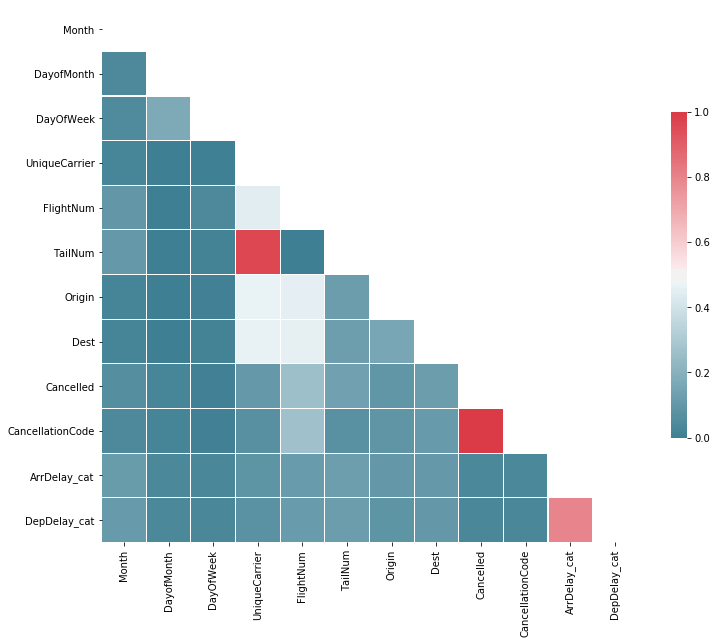

In [26]:
features_cat_cor = features_cat
# считаем корреляции
conf_matrix_cor = pd.DataFrame(1.0, index=features_cat_cor, columns=features_cat_cor)
for feat in itertools.combinations(features_cat_cor, 2):
    conf_matrix_cor.loc[feat[0], feat[1]] = get_cramers_cor(data[feat[0]], data[feat[1]])
    conf_matrix_cor.loc[feat[1], feat[0]] = conf_matrix_cor.loc[feat[0], feat[1]]

# маска треугольника
mask = np.zeros_like(conf_matrix_cor, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# параметры графика
f, ax = plt.subplots(figsize=(12, 12))

# палитра
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# отрисовка тепловой карты
sns.heatmap(conf_matrix_cor, mask=mask, cmap=cmap, vmax=1.0, vmin=0.0,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.1, cbar_kws={"shrink": .5}, ax=ax)
plt.show()

In [254]:
conf_matrix_cor

,Month,DayofMonth,DayOfWeek,UniqueCarrier,FlightNum,TailNum,Origin,Dest,Cancelled,CancellationCode,ArrDelay_cat,DepDelay_cat
Month,1.000000,0.042357,0.047663,0.025548,0.097721,0.109043,0.023184,0.022775,0.060541,0.039901,0.119254,0.110599
DayofMonth,0.042357,1.000000,0.175005,0.002998,0.000000,0.000000,0.000000,0.000000,0.025999,0.023002,0.035450,0.035552
DayOfWeek,0.047663,0.175005,1.000000,0.006223,0.042702,0.016106,0.011415,0.016963,0.008915,0.010901,0.032990,0.034012
UniqueCarrier,0.025548,0.002998,0.006223,1.000000,0.441698,0.962224,0.466959,0.463946,0.108376,0.072833,0.086978,0.079543
FlightNum,0.097721,0.000000,0.042702,0.441698,1.000000,0.000000,0.453763,0.458305,0.261584,0.266952,0.116909,0.117035
TailNum,0.109043,0.000000,0.016106,0.962224,0.000000,1.000000,0.122046,0.128380,0.136917,0.078114,0.127344,0.122749
Origin,0.023184,0.000000,0.011415,0.466959,0.453763,0.122046,1.000000,0.157044,0.097412,0.091760,0.103320,0.089816
Dest,0.022775,0.000000,0.016963,0.463946,0.458305,0.128380,0.157044,1.000000,0.121620,0.111102,0.106746,0.102658
Cancelled,0.060541,0.025999,0.008915,0.108376,0.261584,0.136917,0.097412,0.121620,1.000000,0.999986,0.035973,0.033535
CancellationCode,0.039901,0.023002,0.010901,0.072833,0.266952,0.078114,0.091760,0.111102,0.999986,1.000000,0.035804,0.033352


1. Видим корреляцию на уровне 0,5 между номером рейса с аэропортом и направлением следования (что скорее всего одно и то же). Данная корреляция логична, т.к. номер рейса привязан к направлению и аэропорту 
2. Есть небольшая корреляция на уровне 0,10-0,12 между Задержкой рейса и Месяцем, Номером рейса, Номером самолета, Направлением и Аэропортом
3. И более существенную корреляцию (0,26) между Отменой рейса и Номером рейса. Отмена рейса с Номером самолета, Направлением и Аэропортом - 0,10-0,14

### Выводы

Предварительный анализ показывает, что чувствительные для пассажира переменные (Отмена, Задержка рейса) имеют корреляции с другими числовыми и категориальными переменными датасета.

##### Из данного датасета можно вытащить еще много интересных инсайтов. Видно, что бывают не только задержки отлетов и прилетов, но и вылеты и прилеты раньше расписания